# Barrier Options Simulation

### What is a Barrier Option?
Barrier options are a class of **exotic options** whose payoff depends not only on the terminal
underlying price $S_T$, but also on whether the underlying has **touched a pre-specified barrier**
level $H$ during the option’s life.

- **Knock-out options:** become worthless if the barrier is breached. -- **The One that we focus**  
  - *Example:* Down-and-out call – pays $(S_T-K)^+$ **only if** the asset price never falls
    below the barrier $H$.  

- **Knock-in options:** only come into existence if the barrier is breached.  
  - *Example:* Up-and-in call – worthless unless the asset price touches an upper barrier $U$. 

- **Scope: In this demo we focus on knock-out options (knock-in can be obtained by parity relations)**

### Why they matter in markets
- **Cost reduction:** Cheaper than vanilla options, since the barrier condition reduces the
likelihood of payout.  
- **Structured products:** Widely embedded in retail and institutional notes to tailor payoffs
(e.g. autocallables).  
- **Trading desks:** Standard instruments on exotics desks; accurate pricing requires handling
continuous monitoring and path-dependence.

### Key Idea
- **Knock-out options** (e.g. down-and-out call) are deactivated if the asset ever hits a barrier during $[0,T]$.
- True survival event:
  \begin{equation}
  \min_{0\le t\le T} S_t > H.
  \end{equation}

### Problem: Discrete Simulation
- Monte Carlo usually samples on a grid $0=t_0 < \dots < t_M=T$.
- Naïve check: survive if $S_{t_i} > H$ for all grid points.
- **Issue:** path may dip below $H$ between sampling times → **missed knock-outs**.
- Result: **upward bias** (price too high) for knock-out options.

### Brownian Bridge Correction
- Condition on endpoints $X_{t_i}, X_{t_{i+1}}$ with $X=\ln S$.
- Between them, the process is a **Brownian bridge**.
- Probability of hitting a lower barrier $h=\ln H$ in $[t_i, t_{i+1}]$:
  \begin{equation}
  p_i = \exp\!\left(-\frac{2\,(X_{t_i}-h)(X_{t_{i+1}}-h)}{\sigma^2 \Delta t_i}\right),
  \end{equation}
  if both endpoints are above $h$, else $p_i=1$.

### Corrected Estimators
1. **Survival weight method (lower variance):**
   \begin{equation}
   \widehat{C} = e^{-rT}\,\frac{1}{N}\sum_{n=1}^N (S_T^{(n)}-K)^+ \prod_{i}(1-p_i^{(n)}).
   \end{equation}

2. **Bernoulli knock-out method (more intuitive):**
   - For each interval, flip a coin with probability $p_i$.
   - If any hit occurs → payoff = 0, else payoff = $(S_T-K)^+$.


In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [5]:
%cd $project_root

/Users/zhaoyub/Documents/Tradings/option-mini-lab


/Users/zhaoyub/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from src.barrier import price_barrier_ko_call, barrier_survival_weights_bridge
from src.gbm import simulate_gbm_paths

### Basic Example: Down-and-Out Call

We price a down-and-out call option with the following parameters:
 - Spot price (S_0 = 100)
 - Strike (K = 100)
 - Barrier (H = 90)
 - Risk-free rate (r = 2%)
 - Volatility (\sigma = 20%)
 - Maturity (T = 1) year
 - Paths: (200,000)
 - Steps: 64

In [9]:
price, se = price_barrier_ko_call(
    S0=100, K=100, r=0.02, sigma=0.2, T=1.0,
    barrier=90.0, kind="down",
    n_steps=64, n_paths=200_000,
    method="bridge_weight",
)
print(f"Down-and-out Call Price: {price:.4f} ± {1.96*se:.4f} (95% CI)")

Down-and-out Call Price: 7.3107 ± 0.0588 (95% CI)


### Comparison: Barrier Removed (Vanilla Call)

If we push the barrier very low (e.g. $H \to 0$), the knock-out option should reduce to the vanilla Black–Scholes call.

In [10]:
price_no_barrier, se_no_barrier = price_barrier_ko_call(
    S0=100, K=100, r=0.02, sigma=0.2, T=1.0,
    barrier=1e-6, kind="down",  # essentially inactive barrier
    n_steps=64, n_paths=200_000,
)
print(f"Vanilla-equivalent Call Price: {price_no_barrier:.4f}")

Vanilla-equivalent Call Price: 8.9001


### Sanity Check: Immediate Knock-Out

If the initial spot is already below the barrier, the option value must be zero.

In [11]:
price_ko, se_ko = price_barrier_ko_call(
    S0=85, K=100, r=0.02, sigma=0.2, T=1.0,
    barrier=90.0, kind="down",
    n_steps=64, n_paths=100_000,
)
print(f"Price with S0 below barrier: {price_ko:.4f}")

Price with S0 below barrier: 0.0000


### Grid Invariance Check

Thanks to the Brownian-bridge correction, the estimated price should not depend on the number of time steps (unlike the naïve discrete approach).

In [12]:
for steps in [8, 32, 128, 512]:
    price, se = price_barrier_ko_call(
        S0=100, K=100, r=0.02, sigma=0.2, T=1.0,
        barrier=90.0, kind="down",
        n_steps=steps, n_paths=100_000,
    )
    print(f"Steps={steps:<4d} → Price: {price:.4f} ± {se:.4f}")

Steps=8    → Price: 7.2591 ± 0.0415
Steps=32   → Price: 7.2693 ± 0.0422
Steps=128  → Price: 7.2926 ± 0.0426
Steps=512  → Price: 7.2864 ± 0.0427


## Visualization

### Simulated Paths with Barrier

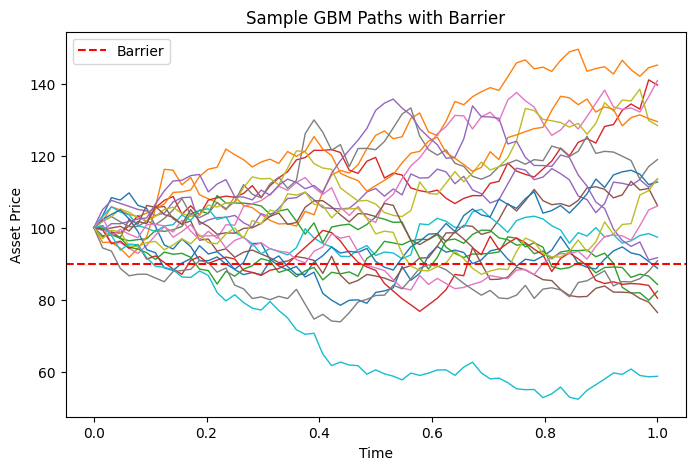

In [15]:
S0, K, r, sigma, T = 100, 100, 0.02, 0.2, 1.0
barrier = 90.0

t, paths = simulate_gbm_paths(S0, mu=r, sigma=sigma, T=T, n_steps=64, n_paths=20, antithetic=False)
plt.figure(figsize=(8,5))
for i in range(paths.shape[0]):
    plt.plot(t, paths[i], lw=1)
plt.axhline(barrier, color="red", ls="--", label="Barrier")
plt.title("Sample GBM Paths with Barrier")
plt.xlabel("Time")
plt.ylabel("Asset Price")
plt.legend()
plt.show()

### Terminal Distribution with vs without Barrier

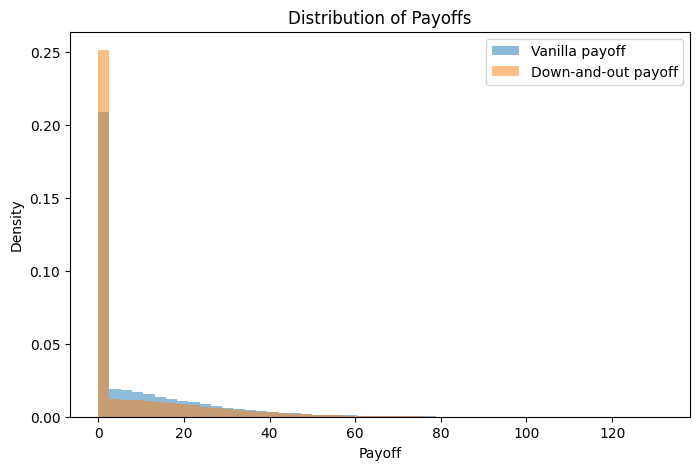

In [16]:
n_paths = 200_000
t, paths = simulate_gbm_paths(S0, mu=r, sigma=sigma, T=T, n_steps=64, n_paths=n_paths)

# Payoffs without barrier
payoff_vanilla = np.maximum(paths[:,-1] - K, 0)

# Survival weights (Brownian bridge)
w = barrier_survival_weights_bridge(paths, sigma=sigma, T=T, barrier=barrier, kind="down")
payoff_barrier = np.maximum(paths[:,-1] - K, 0) * w

plt.figure(figsize=(8,5))
plt.hist(payoff_vanilla, bins=50, alpha=0.5, label="Vanilla payoff", density=True)
plt.hist(payoff_barrier, bins=50, alpha=0.5, label="Down-and-out payoff", density=True)
plt.title("Distribution of Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Density")
plt.legend()
plt.show()

## Summary
 - Discrete monitoring → upward bias in knock-out pricing.
 - Brownian-bridge correction fixes this by computing crossing probabilities between grid points.
 - The corrected estimator is grid-invariant, consistent with vanilla in the barrier → 0/$\infty$ limit, and zero when $S_0$ starts beyond the barrier.
 - Visualizations confirm: the knock-out option has a thinner payoff distribution compared to vanilla because many paths are eliminated.

In [19]:
! jupyter nbconvert --to pdf notebooks/demo_barrier.ipynb

[NbConvertApp] Converting notebook notebooks/demo_barrier.ipynb to pdf
[NbConvertApp] Support files will be in demo_barrier_files/
[NbConvertApp] Making directory ./demo_barrier_files
[NbConvertApp] Writing 38983 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 227649 bytes to notebooks/demo_barrier.pdf
